In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal

In [22]:
class VBGP_PS:
  def __init__(self, num_inducing_points, dim, device="cuda" ):
    self.M = num_inducing_points
    self.D = dim
    self.device = device

    self.theta0 = torch.zeros(1, requires_grad=True, device=self.device )
    self.theta1 = torch.zeros(1, requires_grad=True, device=self.device )
    self.theta2 = torch.rand(1, requires_grad=True, device=self.device )

    self.inducing_points = torch.tensor( (np.random.rand(self.M, self.D)-0.5)*10, requires_grad=True, device=self.device )


  def k(self, xi, xj):
    return torch.exp(self.theta0) * torch.exp(-0.5 * torch.exp(self.theta1) * torch.sum((xi - xj) * (xi - xj), 2)) 
  
  def cov(self, xi, xj ):
    a = xi.view(-1,1,self.D).repeat(1, len(xj), 1)
    b = xj.view(1,-1,self.D).repeat(len(xi), 1, 1)
    return self.k(a,b).float()

  def learn(self, xt, yt, r ):
    self.xt = torch.tensor(xt, dtype=torch.float, device=self.device)
    self.yt = torch.tensor(yt, dtype=torch.float, device=self.device)
    N = len(xt)

    optimizer = torch.optim.Adam( [self.inducing_points, self.theta0, self.theta1, self.theta2], lr=0.1)

    r = torch.tensor(r,  dtype=torch.float, device=self.device)
    self.r = r
    self.W = torch.diag( torch.sqrt(r) )

    for i in range(1000):
      # カーネル行列を定義
      self.Kmm = self.cov( self.inducing_points, self.inducing_points )
      self.Kmm_inv = torch.inverse( self.Kmm+torch.eye(self.M, self.M, device=self.device)*0.001 )
      self.Knm = self.cov( self.xt, self.inducing_points )      

      self.Kmn = torch.t( self.Knm )
      self.Knn = self.cov( self.xt, self.xt )
      self.Knn_ = torch.mm( torch.mm(self.Knm, self.Kmm_inv), self.Kmn )

      self.sig2 = torch.exp( self.theta2 ) + 0.01


      # 報酬で重み付けした行列
      self.WKnm = torch.mm( self.W, self.Knm )
      self.WKmn = torch.t( self.WKnm )
      self.WKnn_ = torch.mm( torch.mm(self.WKnm, self.Kmm_inv), self.WKmn )

      # loss関数を定義
      gauss = MultivariateNormal(torch.zeros(N, device=self.device), self.sig2*torch.eye(N, device=self.device)+self.WKnn_)
      loss = -gauss.log_prob( self.yt ) + torch.trace( self.Knn - self.Knn_ ) / (2*self.sig2)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # 論文中のΣ，A,B
      self.S = torch.inverse( self.Kmm + 1/self.sig2 * torch.mm(self.WKmn, self.WKnm)  + torch.eye(self.M, self.M, device=self.device)*0.001)
      A = torch.mm( torch.mm(self.Kmm, self.S ), self.Kmm )
      self.B = torch.mm(torch.mm(self.Kmm_inv, A), self.Kmm_inv )

      if i%100==0:
        print(loss, self.theta0, self.theta1 )
        self.plot()

  def plot(self):
      x = np.linspace( -10,10,100 )
      mu, sigma = self.predict( x.reshape(-1,1) )
      plt.plot( x, mu )
      
      sigma = np.diag(sigma)
      y_max = mu + np.sqrt(sigma)
      y_min = mu - np.sqrt(sigma)

      plt.fill_between(x, y_min, y_max, facecolor="lavender" , alpha=0.9 , edgecolor="lavender"  )

      for p in self.inducing_points.detach().cpu().numpy():
        plt.plot( p, [0.0], "kx" )
      
      # 報酬が高い点だけプロット
      plt.plot(self.xt[self.r>0.8].cpu(), self.yt[self.r>0.8].cpu(), "x")
      plt.show()

  def predict( self, x ):
    K = len(x)
    x = torch.tensor(x, device=self.device).reshape(-1,self.D)

    Kxm = self.cov( x, self.inducing_points )
    Kmx = torch.t( Kxm )

    sig = self.cov(x, x)
    sig += -torch.mm(torch.mm( Kxm, self.Kmm_inv), Kmx)
    sig += torch.mm( torch.mm( Kxm, self.B ), Kmx )

    mu = torch.mm(Kxm, self.Kmm_inv )
    mu = torch.mm(mu, 1/self.sig2 * torch.mm( torch.mm( torch.mm( self.Kmm, self.S ), self.WKmn), self.yt.reshape(-1,1) ) )
        
    return mu.detach().cpu().numpy().flatten(), sig.detach().cpu().numpy()

  def sample(self, x):
    mu, sigma = self.predict( x )
    y = np.random.multivariate_normal(mu, sigma, size=1)
    return y[0]


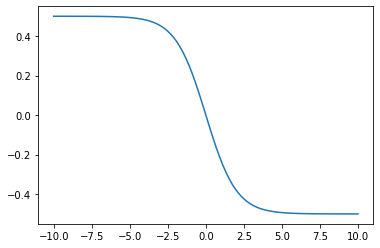

In [13]:
# 適当な関数に近いと報酬が大きくなるよにする
def func(x):
  return 1/(1+np.exp(x))-0.5

def reward(x, y):
  return np.exp( -( 5*((y-func(x)))**2 ) )

x_true = np.linspace( -10, 10, 100 )
y_true = func(x_true)

plt.plot( x_true, y_true, "-" )

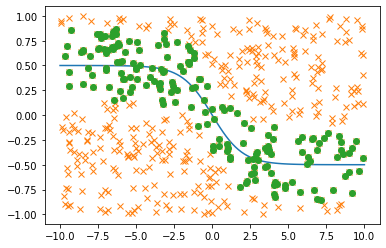

In [14]:
# ランダムに行動して報酬を計算
xt = (np.random.rand(500) -0.5) * 20
yt = (np.random.rand(500)-0.5) * 2
r = reward( xt, yt )

plt.plot( x_true, y_true, "-" )
plt.plot( xt, yt, "x" )
plt.plot( xt[r>0.5], yt[r>0.5], "o" )


tensor([702.0257], device='cuda:0', grad_fn=<AddBackward0>) tensor([-0.1000], device='cuda:0', requires_grad=True) tensor([-0.1000], device='cuda:0', requires_grad=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in sqrt


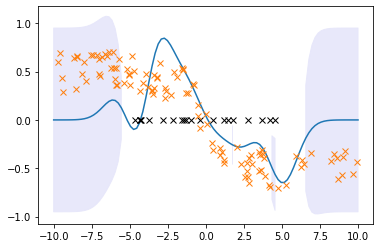

tensor([378.1966], device='cuda:0', grad_fn=<AddBackward0>) tensor([-2.0962], device='cuda:0', requires_grad=True) tensor([-3.3772], device='cuda:0', requires_grad=True)


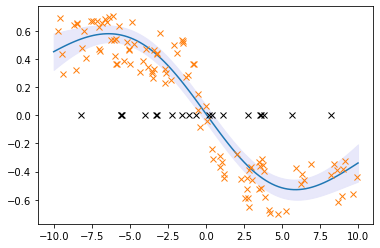

tensor([377.8398], device='cuda:0', grad_fn=<AddBackward0>) tensor([-1.7400], device='cuda:0', requires_grad=True) tensor([-3.4975], device='cuda:0', requires_grad=True)


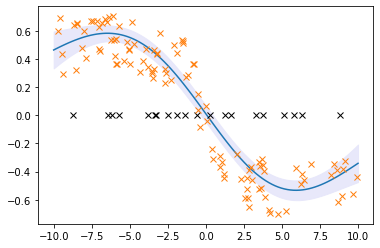

tensor([377.7447], device='cuda:0', grad_fn=<AddBackward0>) tensor([-1.6432], device='cuda:0', requires_grad=True) tensor([-3.5279], device='cuda:0', requires_grad=True)


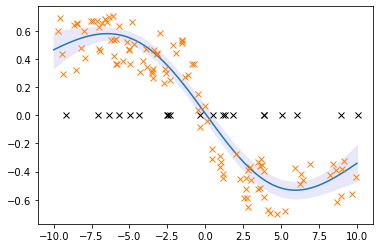

tensor([377.6993], device='cuda:0', grad_fn=<AddBackward0>) tensor([-1.6243], device='cuda:0', requires_grad=True) tensor([-3.5271], device='cuda:0', requires_grad=True)


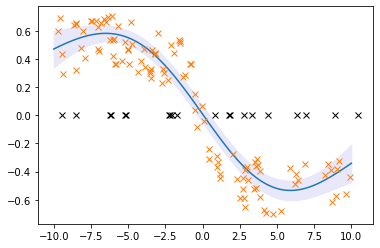

tensor([377.6901], device='cuda:0', grad_fn=<AddBackward0>) tensor([-1.6209], device='cuda:0', requires_grad=True) tensor([-3.5282], device='cuda:0', requires_grad=True)


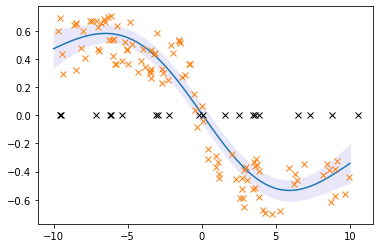

tensor([377.6847], device='cuda:0', grad_fn=<AddBackward0>) tensor([-1.6196], device='cuda:0', requires_grad=True) tensor([-3.5343], device='cuda:0', requires_grad=True)


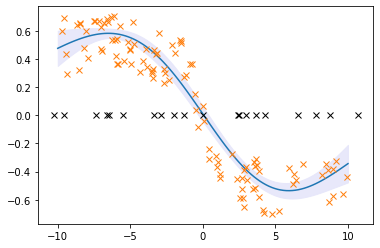

tensor([377.6835], device='cuda:0', grad_fn=<AddBackward0>) tensor([-1.6191], device='cuda:0', requires_grad=True) tensor([-3.5341], device='cuda:0', requires_grad=True)


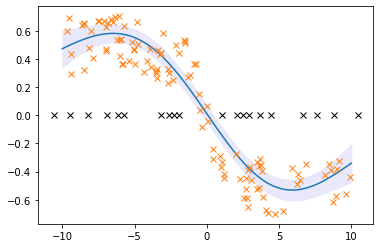

tensor([377.6878], device='cuda:0', grad_fn=<AddBackward0>) tensor([-1.6179], device='cuda:0', requires_grad=True) tensor([-3.5299], device='cuda:0', requires_grad=True)


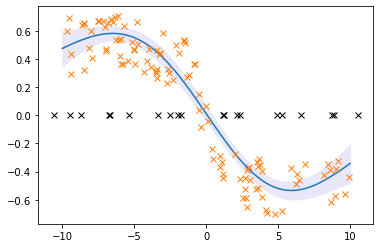

tensor([377.6822], device='cuda:0', grad_fn=<AddBackward0>) tensor([-1.6180], device='cuda:0', requires_grad=True) tensor([-3.5343], device='cuda:0', requires_grad=True)


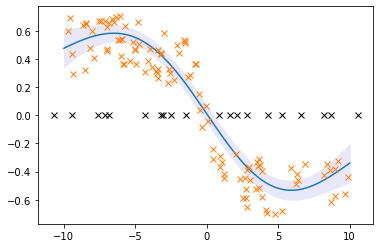

In [25]:
# GPを学習
gp = VBGP_PS( 20, 1, "cuda" )
gp.learn( xt.reshape((-1,1)), yt, r )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/p

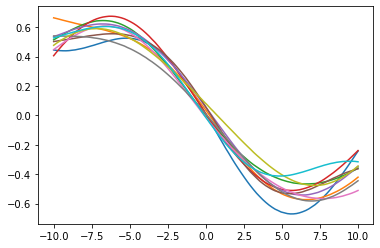

In [26]:
# サンプリング
x = np.linspace(-10,10,100)
for _ in range(10):
  y = gp.sample(x)
  plt.plot(x, y)